# Work on the Debugging (11/28/2023)

Working on the debugging of the model and working out the task in hand. Also checking if I am doing correct or not.

Do the quantization of the model, and the conversion of the data, all in one notebook along with the model inference.

<span style="color:red;">
  
1. Standardize the P_T value before quantizing.
2. Three P_T plots:
    1. Raw P_T (Number of particles vs P_T (GeV))
    2. P_T after standardization (X-axis should be arbitrary units)
    3. After int8 quantization. Centers at 0 and range should be between -127, 127)
      
3. Upon standardization, there could be a few values which could be out of the range of (-127, 127). How to deal with the outliers? One of the methods is to put all of them in the last bin. Are there any other methods available?
  
4. Fix bin size does not give resolution. We can lose information if we discard those outliers.
  
5. Print the true and predicted P_T values. Should be in the INT8 range.
  
6. Put on the distribution if it makes sense.
</span>

<span style="color:green;">
    
1. Read about the dataset
    
2. Understand the outputs what you are plotting
</span>


**Date(11/28/2023)**
1. We need to standradization to whole datasample which is 100 in our case. 
2. Plot the datasample before and after standradization ??
3. Or do we only need to standradize the True P_T?
4. What type of output you have right now?

Links:-
1. https://www.tensorflow.org/lite/performance/post_training_integer_quant
2. https://www.tensorflow.org/lite/performance/post_training_quantization
3. https://www.tensorflow.org/lite/models/convert/
4. https://www.tensorflow.org/lite/performance/post_training_quant
5. https://www.tensorflow.org/lite/performance/post_training_float16_quant 
6. https://www.tensorflow.org/lite/performance/post_training_integer_quant_16x8 
7. https://www.tensorflow.org/lite/performance/quantization_spec 
8. https://arxiv.org/pdf/1712.05877.pdf

***DATE(11.29.2023)***

` The dataset contains input features and target features consist of different things like pT, eta, phi etc. so all of those need to be standardized and quantized separately. but you can start with just pT`
Task:
1. Since working only on the `pT`, quntize it after standradization. Further Check the plots before and after quantization.

Quantize the dataset after stnadradization and then do the inference. Check the output plots 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT 

2023-11-29 18:09:11.477452: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 18:09:13.221040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to JupyROOT 6.28/11


In [2]:
import sys 
sys.path += ["../../../mlpf/particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [3]:
config, _ = parse_config("../../../mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus

In [4]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))


2023-11-29 18:10:26.541753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 18:10:26.582809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 18:10:26.584915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [6]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## These files hosted at https://huggingface.co/jpata/particleflow/tree/clic_clusters_v1.6

In [7]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")



In [8]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [9]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)


In [10]:
tf_dataset

<_PaddedBatchDataset element_spec={'ygen': TensorSpec(shape=(None, None, 8), dtype=tf.float32, name=None), 'ycand': TensorSpec(shape=(None, None, 8), dtype=tf.float32, name=None), 'X': TensorSpec(shape=(None, None, 17), dtype=tf.float32, name=None)}>

In [11]:
data = list(tfds.as_numpy(tf_dataset))


In [12]:
data_df = pd.DataFrame(data)
data_df.head()

,ygen,ycand,X
0,"[[[1.0, -1.0, 6.788085, 0.41524443, 0.19658889...","[[[1.0, -1.0, 6.7846265, 0.41535425, 0.1962670...","[[[1.0, 6.7891545, 0.41534743, 0.19626075, 0.9..."
1,"[[[1.0, 1.0, 4.84474, -0.566881, -0.2552848, 0...","[[[1.0, 1.0, 4.850026, -0.56722957, -0.2554008...","[[[1.0, 4.854712, -0.567271, -0.2553487, 0.966..."
2,"[[[1.0, 1.0, 17.19036, 0.5053377, 0.99092686, ...","[[[1.0, 1.0, 17.217678, 0.5053491, 0.9909401, ...","[[[1.0, 17.228794, 0.5053527, 0.99094075, -0.1..."
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [3...","[[[1.0, 0.85390717, -1.8396752, -0.9325141, -0..."
4,"[[[4.0, 1.0, 9.017672, -1.0024999, 0.47162125,...","[[[4.0, 1.0, 8.953204, -1.0025415, 0.47186264,...","[[[1.0, 8.958021, -1.0025418, 0.47184667, 0.88..."


Inference and Plotting:
* Extracting input features (Xs) and ground truth labels (ys) from the dataset.
* Iterating over batches and making predictions using the pre-trained model.
* Extracting true and predicted transverse momenta (true_pt and pred_pt) and plotting a histogram.

In [18]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [14]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

2023-11-29 15:23:44.326813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


In [15]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

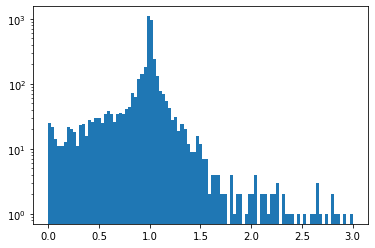

In [16]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

### pT(GeV) Plot before standradization


In [19]:
print(true_pt.shape)
print(pred_pt.shape)

(4250,)
(4250,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: true_pT (Potential memory leak).


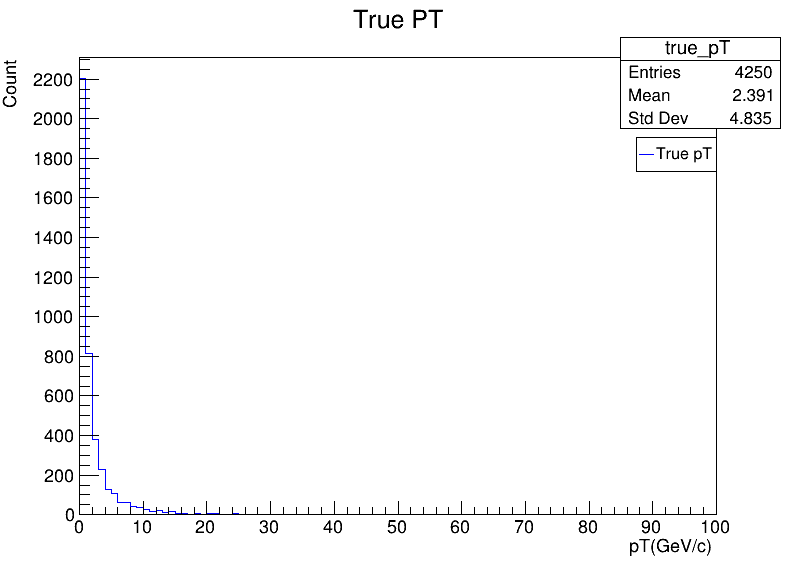

In [43]:
import ROOT
canvas = ROOT.TCanvas("canvas", "True PT", 800, 600)

true_pt_array = np.array(true_pt)

true_hist = ROOT.TH1F("true_pT", "True PT", 100, 0, 100)  

# Filling histograms
for value in true_pt_array:
    true_hist.Fill(value)

true_hist.SetLineColor(ROOT.kBlue)

true_hist.Draw()


# Add legend
legend = ROOT.TLegend(0.8, 0.7, 0.9, 0.76)
legend.AddEntry(true_hist, "True pT", "l")
legend.Draw()

true_hist.GetXaxis().SetTitle("pT(GeV/c)")
true_hist.GetYaxis().SetTitle("Count")

canvas.Draw()

In [44]:
# Extracting the pT value from the data 
# Use extend instead of append to flatten the list

Batch 1 - True pt: [6.78808498e+00 3.70126319e+00 3.91250396e+00 1.00993001e+00
 2.44734097e+00 1.30126143e+00 8.03682804e-01 5.22448897e-01
 4.77299541e-01 4.51308191e-01 4.56495196e-01 3.49737793e-01
 2.55441993e-01 2.19907016e-01 2.13535219e-01 1.15893126e-01
 3.31880957e-01 1.28647137e+00 3.78754973e-01 6.89719141e-01
 4.54732865e-01 7.07714856e-01 3.14400911e-01 2.73779082e+00
 2.38308325e-01 1.03369296e-01 2.22622603e-01 5.56308448e-01
 1.53369665e-01 2.43073121e-01 1.83227107e-01 4.19161767e-01
 1.50058478e-01 5.93001485e-01 2.95784712e-01 4.25821275e-01
 9.50230241e-01 5.91189921e-01 1.41993964e+00 9.19228673e-01
 7.37955332e-01 1.93532217e+00 2.28500390e+00 3.45197439e+00
 8.86907387e+00 4.70913458e+00 3.57476068e+00 2.42714381e+00
 2.21707845e+00 2.09739494e+00 2.07184839e+00 1.67878985e+00
 1.48987424e+00 1.11521327e+00 1.03212368e+00 9.38258290e-01
 8.11255515e-01 6.89630926e-01 6.85662806e-01 5.84369779e-01
 5.40036976e-01 4.48591918e-01 3.65058005e-01 3.57289225e-01
 3.34

Batch 2 - True pt: [4.84473991e+00 1.10971236e+00 3.33634555e-01 2.97950506e-01
 2.38398850e-01 9.58625734e-01 1.40316498e+00 4.45673585e-01
 6.23602271e-01 2.52672195e-01 3.24296385e-01 3.40190768e-01
 6.52691200e-02 1.34115756e-01 8.78640413e-01 4.53572810e-01
 5.08474827e-01 1.53729165e+00 9.34830606e-01 2.69349194e+01
 2.26567326e+01 1.54762926e+01 1.06877403e+01 7.46158028e+00
 6.43514252e+00 6.04403353e+00 4.91017008e+00 4.81609201e+00
 4.73637629e+00 3.29514885e+00 3.19445014e+00 2.14676142e+00
 2.98153281e+00 2.88415027e+00 2.58322430e+00 2.40904927e+00
 2.28487134e+00 2.28214288e+00 2.16715908e+00 1.94546580e+00
 2.01042032e+00 1.88146734e+00 1.79896176e+00 1.68384266e+00
 1.64290071e+00 1.53913534e+00 1.47684693e+00 1.45536506e+00
 1.36812508e+00 1.40581155e+00 1.37278652e+00 1.28435481e+00
 1.31707263e+00 1.28275859e+00 1.89332283e+00 1.16109562e+00
 1.14571321e+00 1.11980069e+00 1.00617790e+00 9.78401423e-01
 9.25015211e-01 9.55438256e-01 9.25591767e-01 9.46797252e-01
 9.57

Batch 3 - True pt: [1.71903591e+01 1.30317192e+01 1.40859709e+01 9.30948162e+00
 7.20882750e+00 2.76994157e+00 6.35275793e+00 6.18304586e+00
 3.87760830e+00 5.45224762e+00 3.91891193e+00 5.01774597e+00
 4.28025866e+00 3.86192369e+00 3.25360107e+00 3.10195827e+00
 2.90769911e+00 2.37364578e+00 2.27506018e+00 2.29947090e+00
 2.01822233e+00 1.62446976e+00 1.49223971e+00 1.49265575e+00
 1.45631611e+00 1.41180396e+00 1.23180914e+00 1.29078472e+00
 1.04873228e+00 1.03110135e+00 9.00748432e-01 9.12273765e-01
 8.59667659e-01 7.72793174e-01 6.49534941e-01 5.82551241e-01
 5.33352375e-01 4.79735941e-01 4.75630403e-01 4.03108180e-01
 3.49740744e-01 3.56680334e-01 2.78047830e-01 2.74896652e-01
 2.81732857e-01 2.44680882e-01 1.79418743e-01 1.47432372e-01
 7.85103515e-02 4.61504273e-02 3.92774642e-02 3.47172469e-02
 8.17619786e-02 6.78917408e-01 1.12971020e+00 6.53508008e-01
 5.46252787e-01 3.59693795e-01 1.50342870e+00 2.83614904e-01
 4.61096734e-01 2.38939852e-01 4.69305217e-02 1.77556187e-01
 6.59

Batch 4 - True pt: [ 1.4128758   0.43831617  0.19714144  5.925305    5.646845    3.057545
  2.659789    1.9218516   1.8323643   1.0048565   1.0456198   0.8892276
  0.5161006   0.3194896   0.24764821  0.2649507   0.1532237   6.244264
  0.11348529  0.1887573   0.14445528  0.61128855  0.64331305  0.24072282
  0.29272795  0.42680696  1.224327    0.18116269  1.0914422   1.3692398
  2.861041    2.3520799   0.7151285   0.72949827  8.911721    7.380272
  5.770854    3.6737604   3.6236227   2.7361522   2.7509086   2.3463142
  0.95942014  0.93722916  0.70440197  0.5519473   0.45632857  0.4453138
  0.39330292  0.2930175  11.636672    1.9811505   0.678759    0.06329886
  0.13835523  6.406162    0.4823169   0.20829982  1.2217621   0.08001521
  0.19042599  0.5600381   0.3633643   1.3252945   0.8197942   0.25655752
  0.32288343  0.5978498   0.22672413  1.1988736   9.334962    7.607931
 10.749795    4.174114    3.5942705   2.7580519   3.0184546   2.9107108
  2.732802    1.8881439   0.8337247   0.63700

Batch 5 - True pt: [9.01767159e+00 3.06567516e+01 7.03008461e+00 5.24061298e+00
 5.10159922e+00 3.37823915e+00 2.68402028e+00 1.72398818e+00
 1.23578274e+00 1.07335687e+00 9.05132830e-01 8.02549005e-01
 6.19018435e-01 3.07276934e-01 4.03476191e+00 2.02513218e-01
 1.83634853e+00 1.23822403e+00 8.71527612e-01 2.75574923e-01
 1.27184594e+00 1.04795682e+00 5.63482761e-01 1.81043506e+00
 3.35629821e-01 4.72043991e-01 1.54000834e-01 1.16907895e+00
 1.52704433e-01 1.09002066e+00 3.99260134e-01 1.84935498e+00
 3.51663446e+00 1.13798857e+00 3.54496551e+00 4.30731201e+00
 2.01449943e+00 6.90127134e+00 2.11168022e+01 1.25389185e+01
 9.46001720e+00 6.89109373e+00 6.02425146e+00 4.32833815e+00
 4.41924238e+00 3.87312722e+00 2.39966059e+00 2.36584306e+00
 1.88981116e+00 1.51493120e+00 1.33497930e+00 1.08138967e+00
 1.21269298e+00 9.16580617e-01 6.89342976e-01 4.45567340e-01
 3.42486054e-01 2.63408840e-01 8.77051544e+00 1.80119228e+00
 5.46208732e-02 2.79996812e-01 3.47208828e-02 8.36022273e-02
 1.79

Batch 6 - True pt: [2.44528341e+00 2.31099772e+00 2.31449771e+00 2.14383340e+00
 1.73390520e+00 1.40174675e+00 1.26955330e+00 1.14430380e+00
 1.16780365e+00 1.26084304e+00 1.08802295e+00 4.35039341e-01
 5.18669784e-01 5.25600016e-01 4.81170207e-01 4.44836915e-01
 3.63846600e-01 3.48686934e-01 3.37540239e-01 1.74296796e-01
 1.62169337e-01 1.60965949e-01 1.46383107e-01 1.43151283e-01
 1.05275333e-01 3.44957560e-01 3.23534131e-01 1.19837627e-01
 1.15727437e+00 1.32851765e-01 8.87878180e-01 1.79360712e+00
 2.27113292e-01 1.32561743e-01 1.94029063e-01 9.85406414e-02
 9.82521176e-01 1.64848611e-01 3.36515635e-01 2.53425181e-01
 2.92708278e-01 2.77802467e-01 1.10051811e-01 3.42651099e-01
 8.88746828e-02 4.40390944e-01 1.78232503e+00 5.93821764e-01
 1.20266724e+01 9.48940563e+00 7.63536882e+00 7.22784948e+00
 4.64558029e+00 2.65693116e+00 1.60853350e+00 7.79193103e-01
 7.35376179e-01 5.40903211e-01 5.18808961e-01 4.05001402e-01
 7.13741720e-01 1.94521517e-01 1.62275642e-01 4.43585348e+00
 8.61

Batch 7 - True pt: [5.80725956e+00 5.02948332e+00 1.78271961e+00 5.22175491e-01
 2.30937481e+00 1.69483995e+00 1.60646200e+00 1.38756108e+00
 1.16842473e+00 1.27581537e+00 8.51498842e-01 8.00736189e-01
 5.04073679e-01 3.97071481e-01 3.69424939e-01 3.08995342e+00
 3.66181076e-01 2.67935514e-01 2.42069468e-01 1.98488876e-01
 1.91025242e-01 1.94558382e-01 1.71572432e-01 3.34749371e-01
 6.65401071e-02 4.66289110e-02 3.33397484e+00 2.40392648e-02
 9.16430727e-02 1.52496481e+00 2.58637369e-01 1.13619737e-01
 4.67112184e-01 1.66570514e-01 1.00318325e+00 7.31695473e-01
 5.64190686e-01 2.89295614e-01 6.91009685e-02 1.93225354e-01
 2.52704471e-01 2.13386595e-01 2.18748301e-01 8.78938437e-01
 8.24108958e-01 2.57316530e-01 1.36433735e-01 5.54994121e-02
 3.04093897e-01 5.03634989e-01 1.05357301e+00 9.71366405e-01
 6.62553072e-01 7.28744924e-01 1.70270920e+00 1.41153976e-01
 1.89207911e+00 2.53699613e+00 2.43806553e+00 8.78337193e+00
 5.10384023e-01 2.93212438e+00 1.50407171e+01 5.87997246e+01
 1.74

Batch 8 - True pt: [9.8423672e+00 9.0048199e+00 1.0264818e+01 3.7833071e+00 3.3529825e+00
 2.3216813e+00 1.5424533e+00 1.5101255e+00 6.1382389e-01 5.1676321e-01
 4.5554966e-01 1.8927850e-01 1.2404068e-01 1.7936875e+00 2.0376778e-01
 1.6258861e-01 1.6889672e-01 6.7468584e-02 8.2215410e-01 4.8581910e+00
 3.9176404e+00 9.5885432e-01 5.8954740e+00 2.4370584e+00 4.7548227e+00
 8.5461121e+00 5.8394451e+00 3.2618103e+00 1.6415249e+00 1.0897123e+00
 1.4190233e+00 1.4631249e+00 1.1696625e+00 9.2952198e-01 7.1764547e-01
 6.4616132e-01 4.7862789e-01 5.1943564e-01 2.8721187e-01 5.3975862e-02
 4.2342229e+00 2.6056042e+00 3.5045441e-02 2.3011321e-01 1.5027753e+00
 2.9134291e-01 9.3870157e-01 5.2313894e-01 9.6224535e-01 3.1408128e-01
 3.0728453e-01 1.5709013e+00 2.4720116e+00 1.5515522e+00 7.2590157e-02
 3.1617393e+00 1.0098068e+00 1.9030122e+00 9.7573066e-01 2.1668913e+00
 1.6056376e+00 1.1206756e+00 9.1324365e-01 3.0204661e+00 9.7592437e-01
 5.9436005e-01 2.6651025e+00 5.9065471e+00 4.1392021e+00 3

Batch 9 - True pt: [8.96394539e+00 2.50914459e+01 1.66521156e+00 4.05083504e+01
 5.28928804e+00 6.10063553e+00 2.95216393e+00 2.77409482e+00
 2.15352750e+00 1.95576394e+00 1.95444584e+00 2.74252462e+00
 1.43573773e+00 1.19547653e+00 1.16561115e+00 9.36463296e-01
 8.28847647e-01 6.79909468e-01 1.27423656e+00 5.07600725e-01
 1.96586704e+01 6.01985872e-01 1.58283234e+00 2.69698352e-01
 1.15199305e-01 2.00230336e+00 2.92819172e-01 2.66663611e-01
 4.87959445e-01 2.19092339e-01 3.23235005e-01 8.58320355e-01
 6.65631437e+00 2.80388093e+00 1.48764572e+02 1.07615364e+00
 2.41560078e+00 2.90793085e+00 4.80418348e+00 6.86552658e+01
 2.94152241e+01 2.33981838e+01 2.40232792e+01 1.85232677e+01
 1.11635942e+01 1.06162167e+01 9.16890049e+00 7.80761003e+00
 6.91261196e+00 5.51128340e+00 5.01500702e+00 4.40952396e+00
 3.22863483e+00 2.79761386e+00 2.81227612e+00 2.36840200e+00
 1.93850410e+00 1.83154082e+00 1.58179915e+00 1.50006402e+00
 8.37529957e-01 5.80966473e-01 8.77820373e-01 5.01737773e-01
 4.35

Batch 10 - True pt: [2.83055472e+00 1.56978226e+00 7.93349862e-01 6.93395674e-01
 2.40793526e-01 1.40060663e-01 3.68100643e-01 1.09536970e+00
 1.20309398e-01 1.11290777e+00 1.14149022e+00 1.05943775e+00
 7.19599247e-01 5.39160788e-01 1.20067716e-01 1.20281540e-01
 4.82295811e-01 1.12619884e-01 6.37133479e-01 2.38523707e-01
 3.32284600e-01 7.36197352e-01 3.54316294e-01 4.51115012e-01
 2.10293308e-01 1.31806707e+00 1.42382491e+00 1.53929749e+01
 8.75705528e+00 4.77058840e+00 3.67022157e+00 3.45241427e+00
 3.48826671e+00 2.53932571e+00 2.46218133e+00 2.48178315e+00
 2.02137947e+00 1.60628104e+00 1.34769070e+00 1.24102807e+00
 1.25102508e+00 1.28881979e+00 6.27256572e-01 5.92347324e-01
 6.06129646e-01 5.66603243e-01 4.38703358e-01 2.89137334e-01
 2.41761595e-01 2.11802348e-01 2.13447049e-01 7.45166242e-02
 1.10498726e+00 1.08167708e+00 3.53399724e-01 1.11198604e-01
 2.76448083e+00 1.09066844e+00 2.76706249e-01 6.37022793e-01
 8.73807892e-02 1.35216653e+00 1.77104545e+00 2.68698845e+01
 3.0

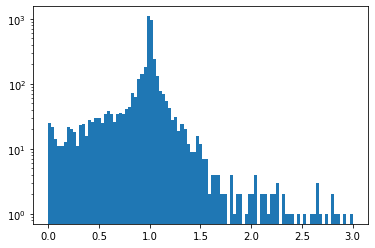

In [46]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0] != 0
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.extend(true_pt)  
    pred_pts.extend(pred_pt) 
    
    print(f"Batch {ibatch + 1} - True pt: {true_pt}, Predicted pt: {pred_pt}")

# Convert the lists to NumPy arrays
true_pt = np.array(true_pts)
pred_pt = np.array(pred_pts)

# Plotting a histogram of the ratio of predicted to true transverse momenta
plt.hist(pred_pt / true_pt, bins=np.linspace(0, 3, 100))
plt.yscale("log")
plt.show()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


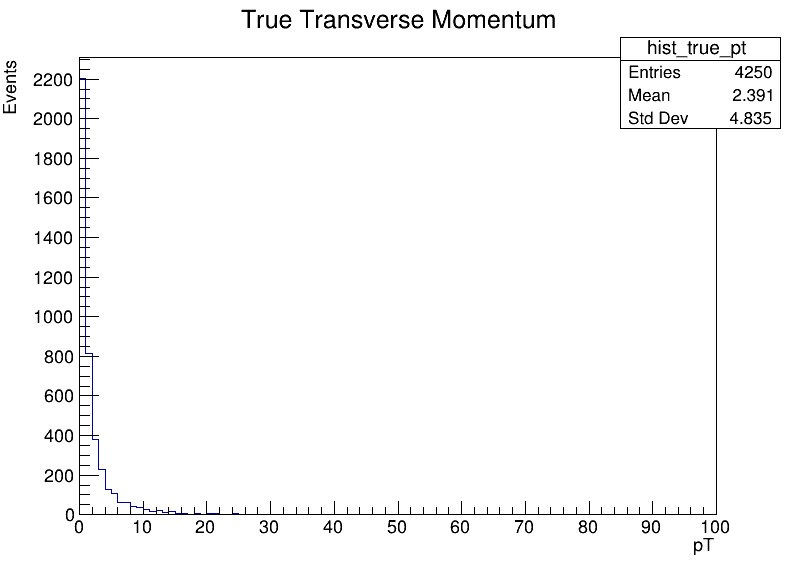

In [47]:
# Convert the true_pt values to a ROOT histogram
hist_true_pt = ROOT.TH1F("hist_true_pt", "True Transverse Momentum; pT; Events", 100, 0, 100)  # Adjust the binning as needed

# Fill the histogram with true_pt values
for value in true_pt:
    hist_true_pt.Fill(value)

# Create a canvas for plotting
canvas = ROOT.TCanvas("canvas", "True Transverse Momentum", 800, 600)

# Draw the histogram
hist_true_pt.Draw()

# Show the canvas
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: hist_true_pt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_pred_pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


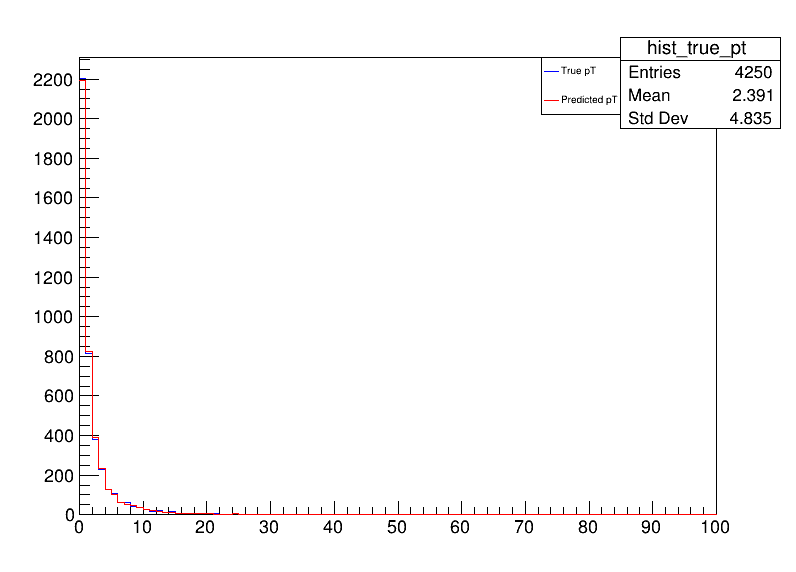

In [77]:


# Convert the true_pt and pred_pt values to ROOT histograms
hist_true_pt = ROOT.TH1F("hist_true_pt", "", 100, 0, 100)  # Adjust the binning as needed
hist_pred_pt = ROOT.TH1F("hist_pred_pt", "Predicted Transverse Momentum; pT; Events", 100, 0, 100)  # Adjust the binning as needed

# Fill the histograms with true_pt and pred_pt values
for true_value, pred_value in zip(true_pt, pred_pt):
    hist_true_pt.Fill(true_value)
    hist_pred_pt.Fill(pred_value)

# Create a canvas for plotting
canvas = ROOT.TCanvas("canvas", "Transverse Momentum", 800, 600)

# Draw the true_pt histogram
hist_true_pt.Draw()
hist_true_pt.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt histogram on the same canvas
hist_pred_pt.Draw("same")
hist_pred_pt.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend = ROOT.TLegend(0.68, 0.80, 0.78, 0.9)
legend.AddEntry(hist_true_pt, "True pT", "l")
legend.AddEntry(hist_pred_pt, "Predicted pT", "l")
legend.Draw()

# Show the canvas
canvas.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: hist_true_pt_scaled (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_pred_pt_scaled (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_scaled


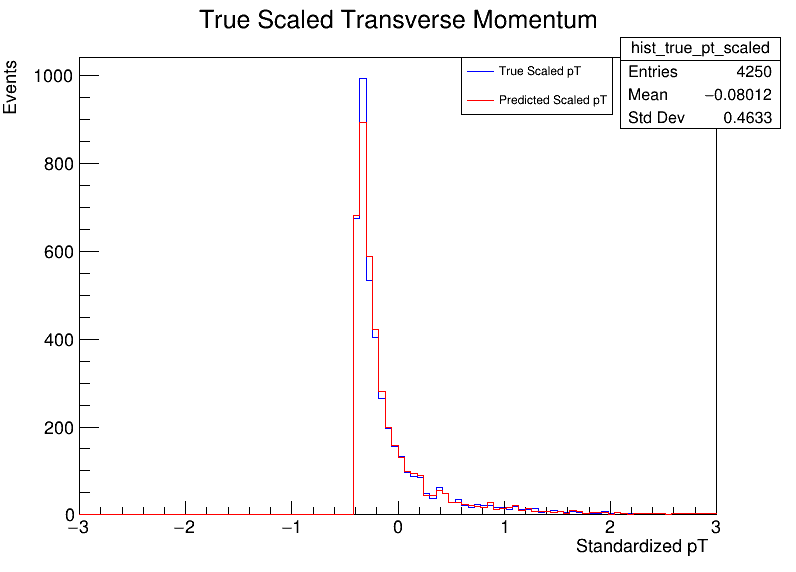

In [58]:
# ...

# Manually standardize true_pt and pred_pt
true_pt_mean = np.mean(true_pt)
true_pt_std = np.std(true_pt)
true_pt_scaled = (true_pt - true_pt_mean) / true_pt_std

pred_pt_mean = np.mean(pred_pt)
pred_pt_std = np.std(pred_pt)
pred_pt_scaled = (pred_pt - pred_pt_mean) / pred_pt_std

# ...

# Convert the true_pt_scaled and pred_pt_scaled values to ROOT histograms
hist_true_pt_scaled = ROOT.TH1F("hist_true_pt_scaled", "True Scaled Transverse Momentum; Standardized pT; Events", 100, -3, 3)
hist_pred_pt_scaled = ROOT.TH1F("hist_pred_pt_scaled", "Predicted Scaled Transverse Momentum; Standardized pT; Events", 100, -3, 3)

# Fill the histograms with true_pt_scaled and pred_pt_scaled values
for i in range(min(len(true_pt_scaled), len(pred_pt_scaled))):
    hist_true_pt_scaled.Fill(true_pt_scaled[i])
    hist_pred_pt_scaled.Fill(pred_pt_scaled[i])

# Create a canvas for plotting
canvas_scaled = ROOT.TCanvas("canvas_scaled", "Scaled Transverse Momentum", 800, 600)

# Draw the true_pt_scaled histogram
hist_true_pt_scaled.Draw()
hist_true_pt_scaled.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt_scaled histogram on the same canvas
hist_pred_pt_scaled.Draw("same")
hist_pred_pt_scaled.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend_scaled = ROOT.TLegend(0.58, 0.8, 0.77, 0.9)
legend_scaled.AddEntry(hist_true_pt_scaled, "True Scaled pT", "l")
legend_scaled.AddEntry(hist_pred_pt_scaled, "Predicted Scaled pT", "l")
legend_scaled.Draw()

# Show the canvas
canvas_scaled.Draw()


To quantize the standardized transverse momentum values, We can round them to a specified number of decimal places or convert them into discrete bins. Here's an example of how you can round the standardized values to a certain number of decimal places:

Applying FP16 Quantization 

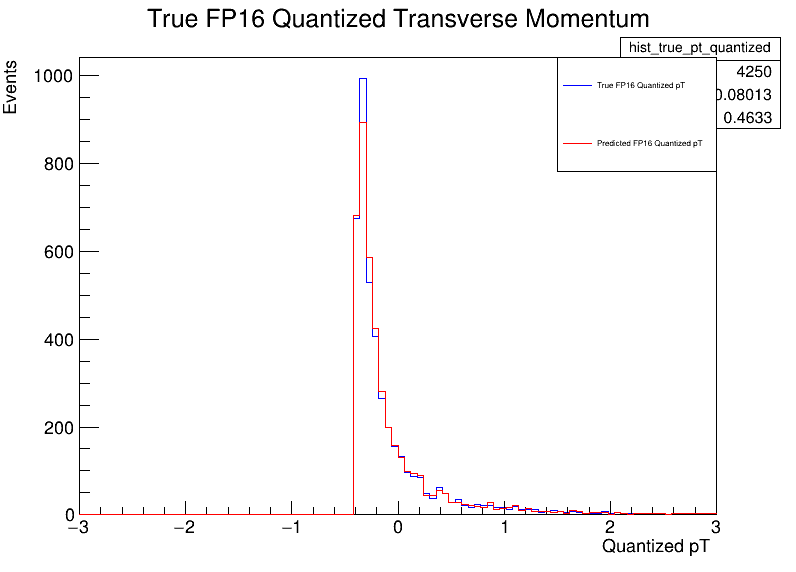

In [59]:
# ...

# Manually standardize true_pt and pred_pt
true_pt_mean = np.mean(true_pt)
true_pt_std = np.std(true_pt)
true_pt_scaled = (true_pt - true_pt_mean) / true_pt_std

pred_pt_mean = np.mean(pred_pt)
pred_pt_std = np.std(pred_pt)
pred_pt_scaled = (pred_pt - pred_pt_mean) / pred_pt_std

# FP16 quantization
true_pt_quantized = true_pt_scaled.astype(np.float16)
pred_pt_quantized = pred_pt_scaled.astype(np.float16)

# ...

# Convert the true_pt_quantized and pred_pt_quantized values to ROOT histograms
hist_true_pt_quantized = ROOT.TH1F("hist_true_pt_quantized", "True FP16 Quantized Transverse Momentum; Quantized pT; Events", 100, -3, 3)
hist_pred_pt_quantized = ROOT.TH1F("hist_pred_pt_quantized", "Predicted FP16 Quantized Transverse Momentum; Quantized pT; Events", 100, -3, 3)

# Fill the histograms with true_pt_quantized and pred_pt_quantized values
for i in range(min(len(true_pt_quantized), len(pred_pt_quantized))):
    hist_true_pt_quantized.Fill(true_pt_quantized[i])
    hist_pred_pt_quantized.Fill(pred_pt_quantized[i])

# Create a canvas for plotting
canvas_quantized = ROOT.TCanvas("canvas_quantized", "FP16 Quantized Transverse Momentum", 800, 600)

# Draw the true_pt_quantized histogram
hist_true_pt_quantized.Draw()
hist_true_pt_quantized.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt_quantized histogram on the same canvas
hist_pred_pt_quantized.Draw("same")
hist_pred_pt_quantized.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend_quantized = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend_quantized.AddEntry(hist_true_pt_quantized, "True FP16 Quantized pT", "l")
legend_quantized.AddEntry(hist_pred_pt_quantized, "Predicted FP16 Quantized pT", "l")
legend_quantized.Draw()

# Show the canvas
canvas_quantized.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: hist_true_pt_quantized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_pred_pt_quantized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_quantized


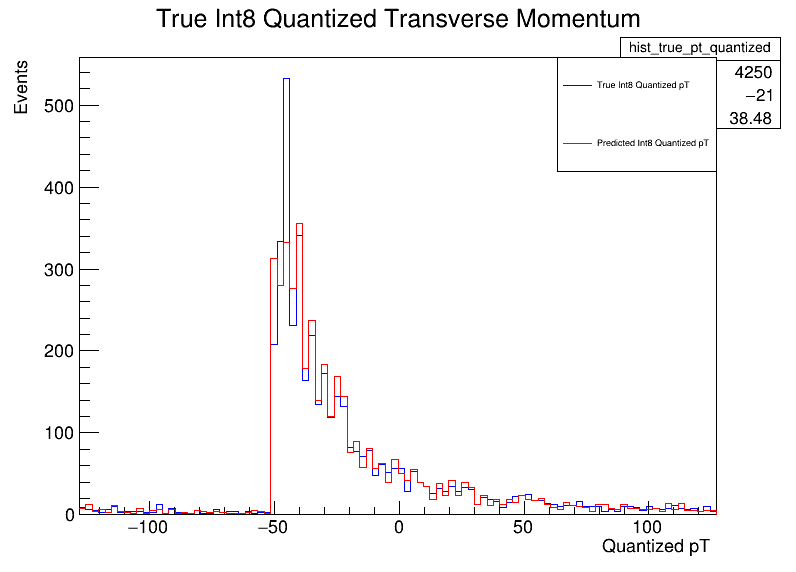

In [60]:
# ...

# Manually standardize true_pt and pred_pt
true_pt_mean = np.mean(true_pt)
true_pt_std = np.std(true_pt)
true_pt_scaled = (true_pt - true_pt_mean) / true_pt_std

pred_pt_mean = np.mean(pred_pt)
pred_pt_std = np.std(pred_pt)
pred_pt_scaled = (pred_pt - pred_pt_mean) / pred_pt_std

# Perform int8 quantization
true_pt_quantized = np.round(true_pt_scaled * 127).astype(np.int8)
pred_pt_quantized = np.round(pred_pt_scaled * 127).astype(np.int8)

# ...

# Convert the true_pt_quantized and pred_pt_quantized values to ROOT histograms
hist_true_pt_quantized = ROOT.TH1F("hist_true_pt_quantized", "True Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)
hist_pred_pt_quantized = ROOT.TH1F("hist_pred_pt_quantized", "Predicted Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)

# Fill the histograms with true_pt_quantized and pred_pt_quantized values
for i in range(min(len(true_pt_quantized), len(pred_pt_quantized))):
    hist_true_pt_quantized.Fill(true_pt_quantized[i])
    hist_pred_pt_quantized.Fill(pred_pt_quantized[i])

# Create a canvas for plotting
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Int8 Quantized Transverse Momentum", 800, 600)

# Draw the true_pt_quantized histogram
hist_true_pt_quantized.Draw()
hist_true_pt_quantized.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt_quantized histogram on the same canvas
hist_pred_pt_quantized.Draw("same")
hist_pred_pt_quantized.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend_quantized = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend_quantized.AddEntry(hist_true_pt_quantized, "True Int8 Quantized pT", "l")
legend_quantized.AddEntry(hist_pred_pt_quantized, "Predicted Int8 Quantized pT", "l")
legend_quantized.Draw()

# Show the canvas
canvas_quantized.Draw()


This process of int8 quantization might lead to values beyond the original range.

***From ChatGPT***

Handling values beyond the original range during quantization is crucial to prevent clipping and ensure a meaningful representation. One common approach is to clip the values to the valid range before quantization.


Warning in <TROOT::Append>: Replacing existing TH1: hist_true_pt_quantized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_pred_pt_quantized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_quantized


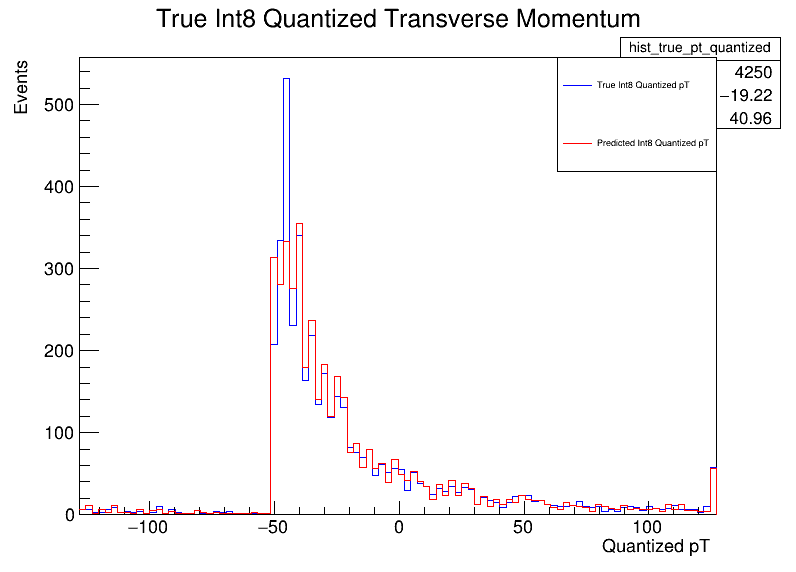

In [61]:
# ...

# Manually standardize true_pt and pred_pt
true_pt_mean = np.mean(true_pt)
true_pt_std = np.std(true_pt)
true_pt_scaled = (true_pt - true_pt_mean) / true_pt_std

pred_pt_mean = np.mean(pred_pt)
pred_pt_std = np.std(pred_pt)
pred_pt_scaled = (pred_pt - pred_pt_mean) / pred_pt_std

# Clip the scaled values to a valid range before int8 quantization
clip_range = (-3, 3)  # Choose a suitable clipping range
true_pt_scaled_clipped = np.clip(true_pt_scaled, clip_range[0], clip_range[1])
pred_pt_scaled_clipped = np.clip(pred_pt_scaled, clip_range[0], clip_range[1])

# Perform int8 quantization
true_pt_quantized = np.round(true_pt_scaled_clipped * 127).astype(np.int8)
pred_pt_quantized = np.round(pred_pt_scaled_clipped * 127).astype(np.int8)

# ...

# Convert the true_pt_quantized and pred_pt_quantized values to ROOT histograms
hist_true_pt_quantized = ROOT.TH1F("hist_true_pt_quantized", "True Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)
hist_pred_pt_quantized = ROOT.TH1F("hist_pred_pt_quantized", "Predicted Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)

# Fill the histograms with true_pt_quantized and pred_pt_quantized values
for i in range(min(len(true_pt_quantized), len(pred_pt_quantized))):
    hist_true_pt_quantized.Fill(true_pt_quantized[i])
    hist_pred_pt_quantized.Fill(pred_pt_quantized[i])

# Create a canvas for plotting
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Int8 Quantized Transverse Momentum", 800, 600)

# Draw the true_pt_quantized histogram
hist_true_pt_quantized.Draw()
hist_true_pt_quantized.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt_quantized histogram on the same canvas
hist_pred_pt_quantized.Draw("same")
hist_pred_pt_quantized.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend_quantized = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend_quantized.AddEntry(hist_true_pt_quantized, "True Int8 Quantized pT", "l")
legend_quantized.AddEntry(hist_pred_pt_quantized, "Predicted Int8 Quantized pT", "l")
legend_quantized.Draw()

# Show the canvas
canvas_quantized.Draw()


To take care of the outliers,  One common approach is to identify and address outliers before quantization. Here's a modification to the code that incorporates a simple outlier handling strategy using the interquartile range (IQR)

Warning in <TROOT::Append>: Replacing existing TH1: hist_true_pt_quantized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_pred_pt_quantized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_quantized


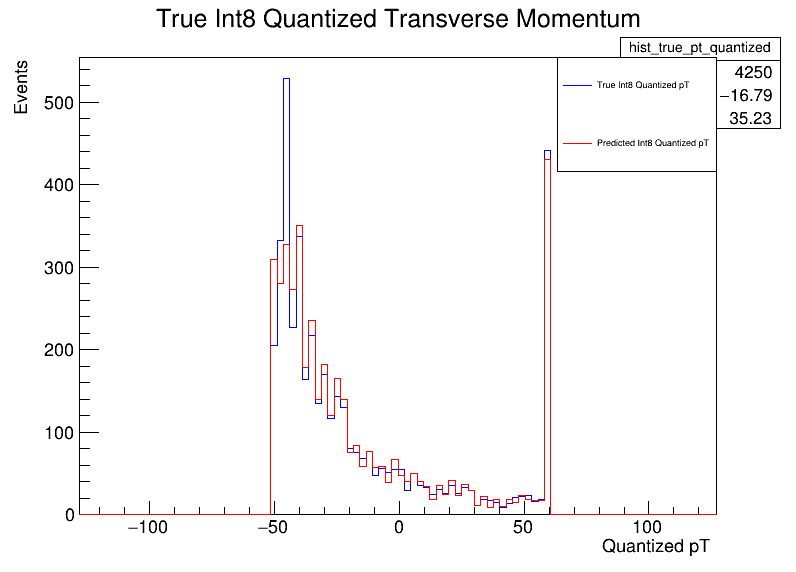

In [62]:
# ...

# Manually standardize true_pt and pred_pt
true_pt_mean = np.mean(true_pt)
true_pt_std = np.std(true_pt)
true_pt_scaled = (true_pt - true_pt_mean) / true_pt_std

pred_pt_mean = np.mean(pred_pt)
pred_pt_std = np.std(pred_pt)
pred_pt_scaled = (pred_pt - pred_pt_mean) / pred_pt_std

# Identify and handle outliers using the interquartile range (IQR)
def handle_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(data, lower_bound, upper_bound)

# Handle outliers in true_pt_scaled and pred_pt_scaled
true_pt_scaled_no_outliers = handle_outliers(true_pt_scaled)
pred_pt_scaled_no_outliers = handle_outliers(pred_pt_scaled)

# Perform int8 quantization
true_pt_quantized = np.round(true_pt_scaled_no_outliers * 127).astype(np.int8)
pred_pt_quantized = np.round(pred_pt_scaled_no_outliers * 127).astype(np.int8)

# ...

# Convert the true_pt_quantized and pred_pt_quantized values to ROOT histograms
hist_true_pt_quantized = ROOT.TH1F("hist_true_pt_quantized", "True Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)
hist_pred_pt_quantized = ROOT.TH1F("hist_pred_pt_quantized", "Predicted Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)

# Fill the histograms with true_pt_quantized and pred_pt_quantized values
for i in range(min(len(true_pt_quantized), len(pred_pt_quantized))):
    hist_true_pt_quantized.Fill(true_pt_quantized[i])
    hist_pred_pt_quantized.Fill(pred_pt_quantized[i])

# Create a canvas for plotting
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Int8 Quantized Transverse Momentum", 800, 600)

# Draw the true_pt_quantized histogram
hist_true_pt_quantized.Draw()
hist_true_pt_quantized.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt_quantized histogram on the same canvas
hist_pred_pt_quantized.Draw("same")
hist_pred_pt_quantized.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend_quantized = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend_quantized.AddEntry(hist_true_pt_quantized, "True Int8 Quantized pT", "l")
legend_quantized.AddEntry(hist_pred_pt_quantized, "Predicted Int8 Quantized pT", "l")
legend_quantized.Draw()

# Show the canvas
canvas_quantized.Draw()


the handle_outliers function is designed to clip outliers based on the interquartile range (IQR) method. It doesn't specifically add outliers to the last bin.

The purpose of using the IQR method is to identify and handle outliers by determining a reasonable range within which most of the data falls. The last bin in the histogram is not specifically targeted for outliers; rather, the data points that fall outside a certain range (determined by the IQR) are clipped to ensure they don't unduly influence the quantization process.

Intentaionally adding the outliers to last bin

Warning in <TROOT::Append>: Replacing existing TH1: hist_true_pt_quantized (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_pred_pt_quantized (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_quantized


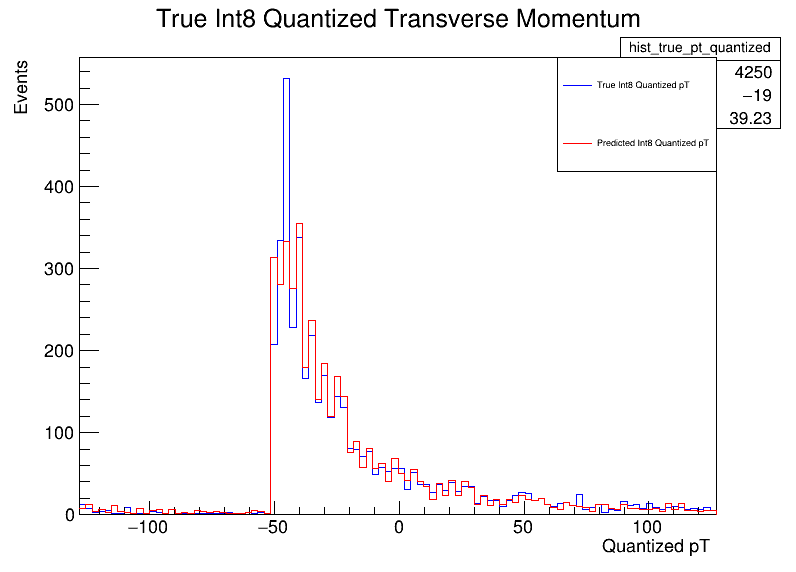

In [63]:
# ...

# Manually standardize true_pt and pred_pt
true_pt_mean = np.mean(true_pt)
true_pt_std = np.std(true_pt)
true_pt_scaled = (true_pt - true_pt_mean) / true_pt_std

pred_pt_mean = np.mean(pred_pt)
pred_pt_std = np.std(pred_pt)
pred_pt_scaled = (pred_pt - pred_pt_mean) / pred_pt_std

# Intentionally add outliers to the last bin
last_bin_outliers_fraction = 0.05  # Adjust as needed
last_bin_min_value = np.percentile(true_pt_scaled, 95)  # Adjust percentile as needed

# Identify values greater than the last_bin_min_value and replace them with outliers
true_pt_scaled_with_outliers = np.copy(true_pt_scaled)
outliers_indices = true_pt_scaled_with_outliers > last_bin_min_value
true_pt_scaled_with_outliers[outliers_indices] = np.random.uniform(last_bin_min_value, true_pt_scaled_with_outliers.max(), np.sum(outliers_indices))

# Perform int8 quantization
true_pt_quantized = np.round(true_pt_scaled_with_outliers * 127).astype(np.int8)
pred_pt_quantized = np.round(pred_pt_scaled * 127).astype(np.int8)

# ...

# Convert the true_pt_quantized and pred_pt_quantized values to ROOT histograms
hist_true_pt_quantized = ROOT.TH1F("hist_true_pt_quantized", "True Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)
hist_pred_pt_quantized = ROOT.TH1F("hist_pred_pt_quantized", "Predicted Int8 Quantized Transverse Momentum; Quantized pT; Events", 100, -128, 127)

# Fill the histograms with true_pt_quantized and pred_pt_quantized values
for i in range(min(len(true_pt_quantized), len(pred_pt_quantized))):
    hist_true_pt_quantized.Fill(true_pt_quantized[i])
    hist_pred_pt_quantized.Fill(pred_pt_quantized[i])

# Create a canvas for plotting
canvas_quantized = ROOT.TCanvas("canvas_quantized", "Int8 Quantized Transverse Momentum", 800, 600)

# Draw the true_pt_quantized histogram
hist_true_pt_quantized.Draw()
hist_true_pt_quantized.SetLineColor(ROOT.kBlue)  # Set line color for better visibility

# Draw the pred_pt_quantized histogram on the same canvas
hist_pred_pt_quantized.Draw("same")
hist_pred_pt_quantized.SetLineColor(ROOT.kRed)  # Set line color for better visibility

# Add a legend
legend_quantized = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend_quantized.AddEntry(hist_true_pt_quantized, "True Int8 Quantized pT", "l")
legend_quantized.AddEntry(hist_pred_pt_quantized, "Predicted Int8 Quantized pT", "l")
legend_quantized.Draw()

# Show the canvas
canvas_quantized.Draw()


In [65]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Convert the new model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)


2023-11-29 16:17:11.157224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-29 16:17:11.157269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-29 16:17:11.161820: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmp_2_hjt06
2023-11-29 16:17:11.217400: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-29 16:17:11.217434: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmp_2_hjt06
2023-11-29 16:17:11.370553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-11-29 16:17:11.429915: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-29 16:17:12.181439: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmp_

In [67]:
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [68]:
# Get input and output tensors
input_tensor_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]['index'])


In [19]:

# Perform inference on the quantized dataset using the quantized TensorFlow Lite model
quantized_true_pts = []
quantized_pred_pts = []

for ibatch in range(len(quantized_dataset)):
    quantized_data = quantized_dataset[ibatch]

    # Assuming Xs is the input feature you want to use for inference
    input_data = quantized_data["X"].astype(np.float32)  # Ensure input is in float32

    # Set input tensor
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    quantized_pred_pt = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Extracting true_pt from the quantized output
    mask_true_particles = quantized_data["ygen"][..., 0] != 0
    quantized_true_pt = quantized_data["ygen"][mask_true_particles, 2]

    quantized_true_pts.append(quantized_true_pt)
    quantized_pred_pts.append(quantized_pred_pt)

# Combine the results into numpy arrays
quantized_true_pt = np.concatenate(quantized_true_pts)
quantized_pred_pt = np.concatenate(quantized_pred_pts)


NameError: name 'quantized_dataset' is not defined

Something we are missing. 
1. I think we have to quantize the pT value nad then use further. 

NameError: name 'np' is not defined